In [60]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import pandas as pd

In [61]:
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 
classes = [i for i in os.listdir(fish_dir) if '.' not in i]                    
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [62]:
label = []
path = []

for dir_name, _,filenames in os.walk(fish_dir):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dir_name.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dir_name)[-1])         # Append the directory name to label 
                path.append(os.path.join(dir_name,filename))     # Append all the png files to path of that directory

data = pd.DataFrame(columns=['path','label'])
data['path']=path
data['label']=label

In [63]:
data['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

In [64]:
batch_size = 20
img_height = 224
img_width = 224

In [65]:
# Prepare data generators with rescaling and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)  # 20% data for validation

In [66]:
train_generator = train_datagen.flow_from_directory(
    directory=fish_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    directory=fish_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical')

Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


In [67]:
# Get the number of classes
num_classes = len(train_generator.class_indices)

In [68]:
# Build the ANN model
model_ann = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_ann.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Print model summary
model_ann.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,462,921 (169.61 MB)

 Trainable params: 44,462,921 (169.61 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model_ann.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15, 
    callbacks=[early_stopping] 
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


720/720 ━━━━━━━━━━━━━━━━━━━━ 1174s 2s/step - accuracy: 0.4318 - loss: 1.5305 - val_accuracy: 0.6917 - val_loss: 0.9866
Epoch 2/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 1169s 2s/step - accuracy: 0.7845 - loss: 0.5790 - val_accuracy: 0.8294 - val_loss: 0.5074
Epoch 3/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 1175s 2s/step - accuracy: 0.9090 - loss: 0.2544 - val_accuracy: 0.7700 - val_loss: 0.8366
Epoch 4/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 1171s 2s/step - accuracy: 0.9565 - loss: 0.1283 - val_accuracy: 0.8467 - val_loss: 0.5575
Epoch 5/15
720/720 ━━━━━━━━━━━━━━━━━━━━ 1216s 2s/step - accuracy: 0.9827 - loss: 0.0603 - val_accuracy: 0.8081 - val_loss: 0.7573


In [70]:
# Evaluate the model
loss, accuracy = model_ann.evaluate(validation_generator)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')

180/180 ━━━━━━━━━━━━━━━━━━━━ 82s 455ms/step - accuracy: 0.8264 - loss: 0.5019
Validation loss: 0.5073531270027161
Validation accuracy: 0.8294444680213928


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

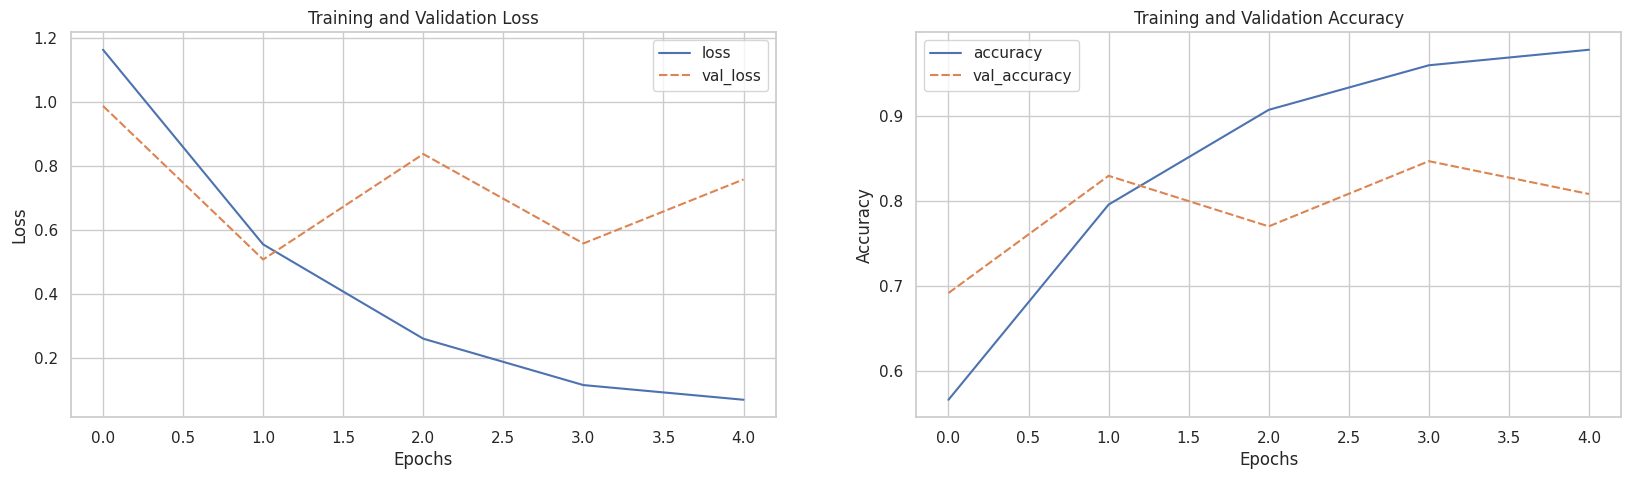

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Eğitim geçmişini DataFrame'e çevir
history_df = pd.DataFrame(history.history)

# Sonsuz (inf) değerleri NaN olarak değiştir
history_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN değerlerini gerekirse doldur veya yok say
history_df.dropna(inplace=True)

# Grafik çizimi
sns.set(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Loss grafiği
sns.lineplot(data=history_df[['loss', 'val_loss']], ax=ax[0])
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

# Accuracy grafiği
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']], ax=ax[1])
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

plt.show()